# 1. EDA

##### 모듈 불러오기

In [125]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [126]:
train = pd.read_csv('train.csv', encoding = 'utf-8')
test = pd.read_csv('test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('sample_submission.csv', encoding = 'utf-8')

##### train/test data 탐색

In [127]:
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [128]:
test.head()

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...


train data는 index, text, author로 구성되어 있고 test data는 index, text로 구성 → author 예측해야함

In [129]:
train['author'].value_counts()

3    15063
0    13235
2    11554
4     7805
1     7222
Name: author, dtype: int64

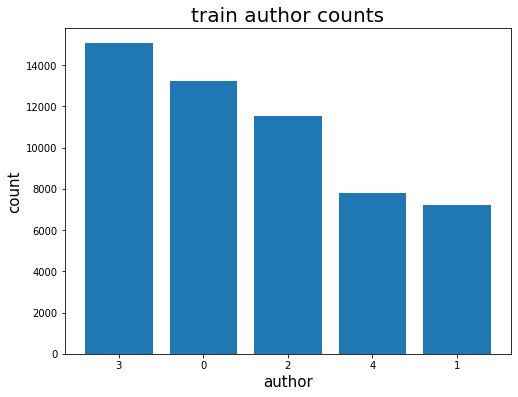

In [130]:
label = ['3','0','2','4','1']
index = np.arange(len(label))

plt.figure(figsize = (8,6))
plt.bar(index, train['author'].value_counts())
plt.title('train author counts', fontsize = 20)
plt.xlabel('author', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.xticks(index, label, fontsize = 10)
plt.show()

train data의 author 수를 보면 author : 3 > 0 > 2 > 4 > 1

# 2. 전처리

##### 영어, 숫자 외의 문자 제외

In [131]:
import re

# ^는 not의 의미
# a-z : 영어 소문자
# A-Z : 영어 대문자
# 0-9 : 숫자
# \s : 띄어쓰기

def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)
test['text']=test['text'].apply(alpha_num)

train.head()

,index,text,author
0,0,He was almost choking There was so much so muc...,3
1,1,Your sister asked for it I suppose,2
2,2,She was engaged one day as she walked in peru...,1
3,3,The captain was in the porch keeping himself c...,4
4,4,Have mercy gentlemen odin flung up his hands D...,3


##### train data의 text length 분포 확인

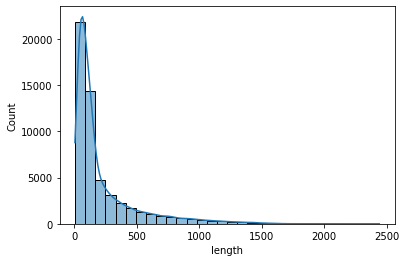

In [132]:
train['length'] = train['text'].map(len)

import seaborn as sns
sns.histplot(data = train['length'], kde = True, bins = 30)

In [133]:
from scipy.stats import skew, kurtosis

print('skew : ',skew(train['length']))
print('kurt : ',kurtosis(train['length']))  #default : fisher = True
# print('kurt : ',kurtosis(train['length'],fisher=False))

#kurt에서 fisher = True로 주면 정규분포의 첨도를 0으로(첨도 기준이 fisher) False로 주면 3으로(첨도 기준이 pearson)

skew :  2.360488175686188
kurt :  6.026636916560131


일반적으로 skew는 절댓값 2, kurt는 7보다 크면 치우쳐진 변수라고 판단

skew > 2이므로 train의 text의 길이는 치우쳐진 변수로 판단됨

##### 불용어 제외 + 소문자로 변환

In [134]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


In [135]:
train['text'] = train['text'].apply(lambda x: x.lower())
test['text'] = test['text'].apply(lambda x: x.lower())

train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

train['text'].head()

0    almost choking much much wanted say strange ex...
1                                 sister asked suppose
2    engaged one day walked perusing janes last let...
3    captain porch keeping carefully way treacherou...
4    mercy gentlemen odin flung hands dont write an...
Name: text, dtype: object

# 3. 새로운 사전(vocab) 생성

##### 품사 리스트 생성
일반적으로 영어에는 조사 없지만 한국어에는 조사 존재 

선어말 어미 등으로 '##' + '단어' -> 품사가 하나가 아닌 두개가 나오게됨

1. Tokenizer 단위 기준 새 vocab 생성 ( 중복 X ) 
2. 형태소 각각에 대한 index 생성 ex) cls -> 1, sep -> 2, cc -> 3 ...
3. 토큰 생성 : train data의 text 각각 문장에 대해 문장 처음 시작 시 cls 표시, 마지막에는 sep 표시
4. 토큰 id 생성 : 새로운 vocab 기준 단어의 index를 추가

bert로 학습 진행 + bert의 최대 학습 길이가 512여서 최대 길이는 512로 설정

In [136]:

import os
import torch
from torch import nn

import pandas as pd
import numpy as np
import random

import nltk
from nltk import FreqDist

import subprocess

document = []
sentences = []

# tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base")
# mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

#https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=kmkim1222&logNo=10185408339
def tagger():
  tagger = [
      "CC", #등위접속사  ex) and, for, nor, but, or ...
      "CD", #기수  ex) one, two, 35, 10 ...
      "DT", #한정사  ex) a, that, any, all, this ...
      "EX", 
      "FW", #외래어  ex) dong, alam ...
      "IN", #전치사  ex) because, ago, under ... 
      "JJ",
      "JJR",
      "JJS",
      "LS",
      "MD",
      "NN",
      "NNS",
      "NP",
      "NPS",
      "PDT",
      "POS",
      "PP",
      "PP$",
      "RB",
      "RBR",
      "RBS",
      "RP",
      "TO",
      "UH",
      "VB",
      "VBD",
      "VBG",
      "VBN",
      "VBP",
      "VBZ",
      "WDT",
      "WP",
      "WP$",
      "WRB"
      ]

  pos_ids = {}
  for i, tag in enumerate(tagger):
    pos_ids[tag] = i + 3    # index 3부터 시작 -> [cls] : 1, [sep] : 2, [cc] : 3

  return pos_ids

In [137]:
sentences = train['text']
sentences.head()

0    almost choking much much wanted say strange ex...
1                                 sister asked suppose
2    engaged one day walked perusing janes last let...
3    captain porch keeping carefully way treacherou...
4    mercy gentlemen odin flung hands dont write an...
Name: text, dtype: object

* 새로운 vocab 생성 시에는 train, test의 text의 모든 단어 활용하여 만들어야함

In [138]:
data = pd.concat([train['text'], test['text']])

In [139]:
MAX_LEN = 512   #bert의 최대 문장 길이
total_len = len(sentences)
input_ids = np.zeros(shape=[total_len, MAX_LEN], dtype="uint8")
input_masks = np.zeros(shape=[total_len, MAX_LEN], dtype="uint8")
input_segments = np.zeros(shape=[total_len, MAX_LEN], dtype=np.int32)
input_pos = np.zeros(shape=[total_len, MAX_LEN], dtype="uint8")
print("total_len: ", total_len)

total_len:  54879


형태소 단위 토큰화

In [140]:
import nltk
from nltk import word_tokenize
# nltk.download('popular')

pos_ids = tagger()
pos_len = len(pos_ids) + 3  # CLS, SEP 때문

output_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']

for sentence in data:
  words = word_tokenize(sentence)
  for word, info in nltk.pos_tag(words):
    output_tokens.append(word)
  if word in output_tokens :
    continue
  output_tokens.append(word)
  
vocab = FreqDist(np.hstack(output_tokens))
print("단어 집합의 크기: ", len(vocab))

단어 집합의 크기:  62377


In [141]:
pos_ids   #형태소에 대한 인덱스 생성

{'CC': 3,
 'CD': 4,
 'DT': 5,
 'EX': 6,
 'FW': 7,
 'IN': 8,
 'JJ': 9,
 'JJR': 10,
 'JJS': 11,
 'LS': 12,
 'MD': 13,
 'NN': 14,
 'NNS': 15,
 'NP': 16,
 'NPS': 17,
 'PDT': 18,
 'POS': 19,
 'PP': 20,
 'PP$': 21,
 'RB': 22,
 'RBR': 23,
 'RBS': 24,
 'RP': 25,
 'TO': 26,
 'UH': 27,
 'VB': 28,
 'VBD': 29,
 'VBG': 30,
 'VBN': 31,
 'VBP': 32,
 'VBZ': 33,
 'WDT': 34,
 'WP': 35,
 'WP$': 36,
 'WRB': 37}

In [144]:
vocab   #train, test 데이터의 문장 내 형태소 단위의 단어에 대한 새로운 vocab(사전) 생성

['[PAD]',
 '[UNK]',
 '[CLS]',
 '[SEP]',
 '[MASK]',
 'almost',
 'choking',
 'much',
 'much',
 'wanted',
 'say',
 'strange',
 'exclamations',
 'came',
 'lips',
 'pole',
 'gazed',
 'fixedly',
 'bundle',
 'notes',
 'hand',
 'looked',
 'odin',
 'evident',
 'perplexity',
 'sister',
 'asked',
 'suppose',
 'engaged',
 'one',
 'day',
 'walked',
 'perusing',
 'janes',
 'last',
 'letter',
 'dwelling',
 'passages',
 'proved',
 'jane',
 'not',
 'written',
 'spirits',
 'instead',
 'surprised',
 'mr',
 'odin',
 'saw',
 'looking',
 'odin',
 'meeting',
 'putting',
 'away',
 'letter',
 'immediately',
 'forcing',
 'smile',
 'said',
 'captain',
 'porch',
 'keeping',
 'carefully',
 'way',
 'treacherous',
 'shot',
 'intended',
 'turned',
 'spoke',
 'us',
 'doctors',
 'watch',
 'lookout',
 'dr',
 'odin',
 'take',
 'north',
 'side',
 'please',
 'jim',
 'east',
 'gray',
 'west',
 'watch',
 'hands',
 'load',
 'muskets',
 'lively',
 'men',
 'careful',
 'mercy',
 'gentlemen',
 'odin',
 'flung',
 'hands',
 'dont',

* train, test 데이터의 문장 내 형태소 단위 단어에 대한 새로운 사전 생성됨

In [142]:
output = open('vocab.txt', 'w', encoding='utf-8')
for token in output_tokens:
    output.write(token + '\n')
output.close()

In [143]:
# vocab to index
voca_file = open('vocab.txt', 'r', encoding='utf-8')
vocab = voca_file.read().split('\n')
word_to_index = {word: index for index, word in enumerate(vocab)}

In [145]:
word_to_index   #새롭게 만든 vocab에 대한 단어 및 index 정보

{'[PAD]': 0,
 '[UNK]': 1,
 '[CLS]': 2,
 '[SEP]': 3,
 '[MASK]': 4,
 'almost': 1938919,
 'choking': 1872402,
 'much': 1938793,
 'wanted': 1938464,
 'say': 1938838,
 'strange': 1934504,
 'exclamations': 1937531,
 'came': 1938276,
 'lips': 1932532,
 'pole': 1869370,
 'gazed': 1920636,
 'fixedly': 1877614,
 'bundle': 1920667,
 'notes': 1924071,
 'hand': 1937823,
 'looked': 1938082,
 'odin': 1938915,
 'evident': 1924292,
 'perplexity': 1894014,
 'sister': 1937975,
 'asked': 1938553,
 'suppose': 1937721,
 'engaged': 1938755,
 'one': 1938944,
 'day': 1938894,
 'walked': 1937447,
 'perusing': 1719909,
 'janes': 1913111,
 'last': 1938845,
 'letter': 1936442,
 'dwelling': 1919974,
 'passages': 1938456,
 'proved': 1934028,
 'jane': 1934591,
 'not': 1938989,
 'written': 1936446,
 'spirits': 1938898,
 'instead': 1938817,
 'surprised': 1935826,
 'mr': 1938855,
 'saw': 1938111,
 'looking': 1936889,
 'meeting': 1937066,
 'putting': 1934925,
 'away': 1938509,
 'immediately': 1934479,
 'forcing': 1935166

In [146]:
data.index = [i for i in range(len(train) + len(test))]
data

0        almost choking much much wanted say strange ex...
1                                     sister asked suppose
2        engaged one day walked perusing janes last let...
3        captain porch keeping carefully way treacherou...
4        mercy gentlemen odin flung hands dont write an...
                               ...                        
74491    end another day two odin growing visibly stron...
74492    afternoon sat together mostly silence watching...
74493    odin carried thanks odin proceeded happiness l...
74494    soon upon odins leaving room mama said odin al...
74495    worse doomed man denouncer wellknown citizen a...
Name: text, Length: 74496, dtype: object

In [147]:
for i in range(len(sentences)):
  tokens = []
  pos = []
  tokens = nltk.word_tokenize(data[i])
  for word, info in nltk.pos_tag(tokens):
    if info not in pos_ids : # 형태소가 pos_ids에 없을 경우
      print(f'{info} is not exist')
      pos_ids[info] = pos_len
      pos_len += 1
    pos.append(pos_ids[info]) # 형태소 index 저장
    w = word
    tokens.append(w)    # 토큰 저장
  pos.insert(0,1) # [CLS] index = 1
  pos.append(2) # [SEP] index = 2
  
  tokens.insert(0, '[CLS]')   #형태소 저장
  tokens.append('[SEP]')   #형태소 저장
  token_ids = []
  
  #token to ids
  for t in tokens:
    token_ids.append(word_to_index[t])
  
  length = len(token_ids)
  if length > MAX_LEN :
    length = MAX_LEN
    
  for j in range(length) :
    input_ids[i, j] = token_ids[j]    #새 vocab의 index 저장
    input_masks[i, j] = 1   #단어가 존재하면 1, 존재하지 않으면 0
    
  length_pos = len(pos)
  if length_pos > MAX_LEN:
    length_pos = MAX_LEN
    
  for j in range(length_pos):
    input_pos[i, j] = pos[j]    # 형태소 index 저장


PRP is not exist
NNP is not exist
PRP$ is not exist
NNPS is not exist
'' is not exist
SYM is not exist
$ is not exist


In [148]:
# save npy
np.save('train_input_ids', input_ids)
np.save('train_input_mask', input_masks)
# np.save('./corpus/input_segments', input_segments)
np.save('train_input_pos', input_pos)

In [149]:
train_input_ids = input_ids

In [150]:
print(input_ids.shape)

(54879, 512)


In [151]:
sentences = test['text']

MAX_LEN = 512
total_len = len(sentences)
input_ids = np.zeros(shape=[total_len, MAX_LEN], dtype="uint8")
input_masks = np.zeros(shape=[total_len, MAX_LEN], dtype="uint8")
input_segments = np.zeros(shape=[total_len, MAX_LEN], dtype=np.int32)
input_pos = np.zeros(shape=[total_len, MAX_LEN], dtype="uint8")
print("total_len: ", total_len)

total_len:  19617


In [152]:
for i in range(len(sentences)):
  tokens = []
  pos = []
  tokens = nltk.word_tokenize(sentences[i])
  for word, info in nltk.pos_tag(tokens):
    if info not in pos_ids : # 형태소가 pos_ids에 없을 경우
      print(f'{info} is not exist')
      pos_ids[info] = pos_len
      pos_len += 1
    pos.append(pos_ids[info]) # 형태소 index 저장
    w = word
    tokens.append(w)    # 토큰 저장
  pos.insert(0,1) # [CLS] index = 1
  pos.append(2) # [SEP] index = 2
  
  tokens.insert(0, '[CLS]')
  tokens.append('[SEP]')
  token_ids = []

  #token to ids
  for t in tokens:
    token_ids.append(word_to_index[t])
  
  length = len(token_ids)
  if length > MAX_LEN :
    length = MAX_LEN
    
  for j in range(length) :
    input_ids[i, j] = token_ids[j]
    input_masks[i, j] = 1
    
  length_pos = len(pos)
  if length_pos > MAX_LEN:
    length_pos = MAX_LEN
    
  for j in range(length_pos):
    input_pos[i, j] = pos[j]


In [153]:
# save npy
np.save('test_input_ids', input_ids)
np.save('test_input_mask', input_masks)
# np.save('./corpus/input_segments', input_segments)
np.save('test_input_pos', input_pos)

test_input_ids = input_ids 

In [154]:
print(input_ids.shape)

(19617, 512)


In [155]:
X_train = train['text']
X_test = test['text']
y_train = train['author']

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
print(y_train)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


# 4. 모델링 (lstm,gru 진행)

In [169]:
#파라미터 설정
vocab_size = 62377 
embedding_dim = 64 
max_length = 512
padding_type='post'

#### lstm 모델링

In [170]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Conv2D, Dropout, Bidirectional

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_length),
    LSTM(32, return_sequences = True),
    LSTM(64, return_sequences = True),
    LSTM(128),
    Dense(5, activation = 'softmax')
])


In [171]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = 0.01))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 512, 64)           3992128   
                                                                 
 lstm_3 (LSTM)               (None, 512, 32)           12416     
                                                                 
 lstm_4 (LSTM)               (None, 512, 64)           24832     
                                                                 
 lstm_5 (LSTM)               (None, 128)               98816     
                                                                 
 dense_16 (Dense)            (None, 5)                 645       
                                                                 
Total params: 4,128,837
Trainable params: 4,128,837
Non-trainable params: 0
_________________________________________________________________


In [172]:
history = model.fit(train_input_ids, y_train, epochs=5)

Epoch 1/5
1715/1715 [==============================] - 92s 51ms/step - loss: 1.5721
Epoch 2/5
1715/1715 [==============================] - 78s 46ms/step - loss: 1.5713
Epoch 3/5
1715/1715 [==============================] - 80s 46ms/step - loss: 1.5711
Epoch 4/5
1715/1715 [==============================] - 82s 48ms/step - loss: 1.5709
Epoch 5/5
1715/1715 [==============================] - 78s 45ms/step - loss: 1.5710


In [173]:
pred = model.predict(test_input_ids)
pred

array([[0.24528147, 0.13260294, 0.2013025 , 0.2844367 , 0.13637638],
       [0.24528147, 0.13260294, 0.2013025 , 0.2844367 , 0.13637638],
       [0.24528147, 0.13260294, 0.2013025 , 0.2844367 , 0.13637638],
       ...,
       [0.24528147, 0.13260294, 0.2013025 , 0.2844367 , 0.13637638],
       [0.24528147, 0.13260294, 0.2013025 , 0.2844367 , 0.13637638],
       [0.24528147, 0.13260294, 0.2013025 , 0.2844367 , 0.13637638]],
      dtype=float32)

In [175]:
sub = pd.read_csv('sample_submission.csv')
sub['0'] = [x[0] for x in pred]
sub['1'] = [x[1] for x in pred]
sub['2'] = [x[2] for x in pred]
sub['3'] = [x[3] for x in pred]
sub['4'] = [x[4] for x in pred]

sub.to_csv('LSTM.csv', index = False)

#### gru 모델링

In [162]:
# model = Sequential([
#     Embedding(vocab_size, embedding_dim, input_length =max_length),
#     Conv1D(32,kernel_size = 3,activation = 'relu'),
#     # Dropout(0.005),
#     Conv1D(64,kernel_size = 3,activation = 'relu'),
#     # Dropout(0.005),
#     Conv1D(128,kernel_size = 3,activation = 'relu'),
#     Dense(5, activation = 'softmax')
#     ])
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Conv1D, Conv2D, Dropout, Bidirectional

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_length),
    GRU(32, return_sequences = True),
    # Dropout(0.005),
    GRU(64, return_sequences = True),
    # Dropout(0.005),
    GRU(128),
    Dense(5, activation = 'softmax')
])

In [163]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = 0.01))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 512, 64)           3992128   
                                                                 
 gru_15 (GRU)                (None, 512, 32)           9408      
                                                                 
 gru_16 (GRU)                (None, 512, 64)           18816     
                                                                 
 gru_17 (GRU)                (None, 128)               74496     
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 4,095,493
Trainable params: 4,095,493
Non-trainable params: 0
_________________________________________________________________


In [164]:
history = model.fit(train_input_ids, y_train, epochs=5)

Epoch 1/5
1715/1715 [==============================] - 80s 44ms/step - loss: 1.6410
Epoch 2/5
1715/1715 [==============================] - 76s 44ms/step - loss: 1.6401
Epoch 3/5
1715/1715 [==============================] - 78s 45ms/step - loss: 1.6379
Epoch 4/5
1715/1715 [==============================] - 79s 46ms/step - loss: 1.6373
Epoch 5/5
1715/1715 [==============================] - 77s 45ms/step - loss: 1.6321


In [165]:
pred = model.predict(test_input_ids)
pred

array([[0.16014273, 0.11562983, 0.20509441, 0.2802011 , 0.23893195],
       [0.18643896, 0.07037114, 0.20575772, 0.3321103 , 0.20532183],
       [0.1563995 , 0.11752095, 0.19503492, 0.28420022, 0.24684438],
       ...,
       [0.15812488, 0.09442929, 0.165931  , 0.34554222, 0.2359726 ],
       [0.16285954, 0.08540557, 0.20840658, 0.324205  , 0.21912329],
       [0.15146679, 0.12832375, 0.16086398, 0.33890072, 0.22044477]],
      dtype=float32)

In [168]:
sub = pd.read_csv('sample_submission.csv')
sub['0'] = [x[0] for x in pred]
sub['1'] = [x[1] for x in pred]
sub['2'] = [x[2] for x in pred]
sub['3'] = [x[3] for x in pred]
sub['4'] = [x[4] for x in pred]

sub.to_csv('GRU.csv', index = False)

# 5. 더 보완했으면 좋을 것들

1. train, validation, test 데이터로 구분하여 학습 진행
2. 교차검증
3. 다양한 모델링 진행 (머신러닝 모델 추가)